# Time Series
## Load Data
The problem is to predict the number of monthly armed robberies in Boston, USA .In this tutorial we use data source from kagle, you can dowload it from this link https://www.kaggle.com/datasets/sujan97/monthly-armed-robberies-in-boston

First, call the Python packages that will be used in ARIMA modeling, as follows:

In [ ]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from google.colab import drive
from statsmodels.graphics.tsaplots import plot_predict
import warnings
warnings.filterwarnings('ignore')

Read the CSV Data from google colab

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/Project/Blog/Data/Robberies.csv")
data.head()

,Months,Robberies
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43


In [ ]:
# change columns Month to datetime
data['Months'] = pd.to_datetime(data['Months'])

# set Month as index
data.set_index("Months",inplace=True)
data.head()

,Robberies
Months,
1966-01-01,41
1966-02-01,39
1966-03-01,50
1966-04-01,40
1966-05-01,43


In [ ]:
# Data Information
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118 entries, 1966-01-01 to 1975-10-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Robberies  118 non-null    int64
dtypes: int64(1)
memory usage: 1.8 KB


## Data Preprocessing
Data processing is the process of converting data into information that can be used in a suitable format for time series analysis purposes.

To check for missing values in the data, you can use the following code in Python

In [ ]:
# cek missing value
data.isnull().sum()

Robberies    0
dtype: int64

In [ ]:
#Split the data into training and testing sets. The test data will be used for the next 3 months.

split_data = len(data)-3
train_data = data[:split_data]
test_data = data[split_data:]
print("training data : ",len(train_data))
print("testing data : ",len(test_data))

training data :  115
testing data :  3


# Model Identification

Data pattern identification: The data used in time series analysis must exhibit stationary data patterns. If the data is non-stationary, researchers must apply differencing techniques to render the data stationary

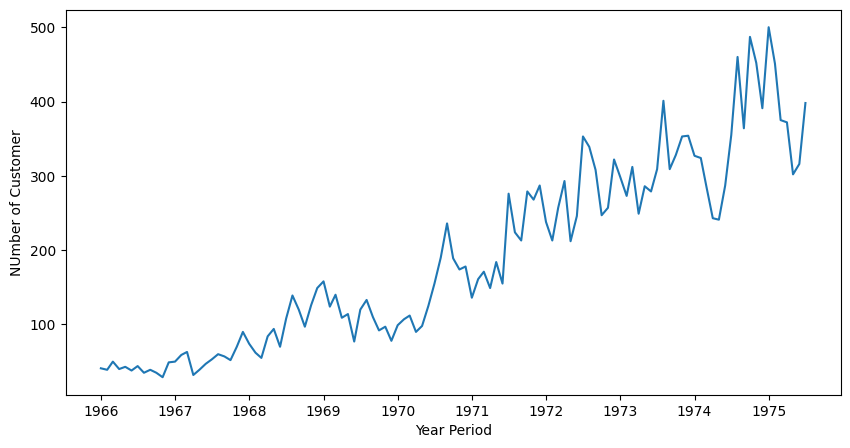

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel("Year Period")
plt.ylabel("NUmber of Customer")
plt.plot(train_data)


From the plot generated above, the data pattern observed is a trend pattern, indicating that the data does not exhibit stationary patterns. To further confirm this observation, a stationarity test is conducted.

## Stationarity Check

Stationarity Test, the following Python script is used to check for stationarity

In [ ]:
def cek_stationary(sales):
    result = adfuller(sales)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('lags-used: {}'.format(result[2]))
    print('number of Observations: {}'.format(result[3]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

cek_stationary(train_data['Robberies'])

ADF Statistic: 1.2091970189217083
p-value: 0.996048813933615
lags-used: 11
number of Observations: 103
Critical Values:
	1%: -3.4954932834550623
	5%: -2.8900369024285117
	10%: -2.5819706975209726


Explanation of the Augmented Dickey-Fuller test (ADF test):

The Augmented Dickey-Fuller test is a statistical test commonly used to determine whether a time series is stationary or not. It is based on the null hypothesis that the time series has a unit root (non-stationary). If the p-value obtained from the test is less than a chosen significance level (e.g., 0.05), then we reject the null hypothesis and conclude that the time series is stationary.

In the script above, we use the adfuller function from the statsmodels library, which returns several outputs:

ADF Statistic: This is the test statistic. If it is more negative (i.e., further from zero) and the absolute value is greater than the critical values, we can reject the null hypothesis and consider the data as stationary.
p-value: This is the p-value obtained from the test. If it is less than the chosen significance level (e.g., 0.05), we can reject the null hypothesis and consider the data as stationary.
Critical Values: These are the critical values at different confidence levels. The ADF Statistic should be compared against these critical values to determine stationarity.
If the ADF Statistic is more negative than the critical values and the p-value is less than the significance level, we can confidently say that the data is stationary. Otherwise, if the p-value is greater than the significance level, we fail to reject the null hypothesis, indicating that the data is non-stationary and requires differencing to achieve stationarity.

## Differencing
Differencing is the process of transforming data to make it exhibit stationary patterns.

In [ ]:
train_data['First Differencing'] = train_data['Robberies'] - train_data['Robberies'].shift(1)
train_data.head()

,Robberies,First Differencing
Months,,
1966-01-01,41,NaN
1966-02-01,39,-2.0
1966-03-01,50,11.0
1966-04-01,40,-10.0
1966-05-01,43,3.0


In [ ]:
stationary_data = train_data[1:]
stationary_data.head()

,Robberies,First Differencing
Months,,
1966-02-01,39,-2.0
1966-03-01,50,11.0
1966-04-01,40,-10.0
1966-05-01,43,3.0
1966-06-01,38,-5.0


After differencing, another stationarity check is performed on the differenced data.

In [ ]:
cek_stationary(stationary_data['First Differencing'])

ADF Statistic: -7.150785212574603
p-value: 3.1452346315173905e-10
lags-used: 10
number of Observations: 103
Critical Values:
	1%: -3.4954932834550623
	5%: -2.8900369024285117
	10%: -2.5819706975209726


Based on the obtained p-value of 3.14e-10 (approximating 0.000), which is less than the significance level of 0.05, the null hypothesis (Ho) is rejected. Therefore, it can be concluded that the data exhibits a stationary pattern, as depicted in the plotted dataset after differentiation.

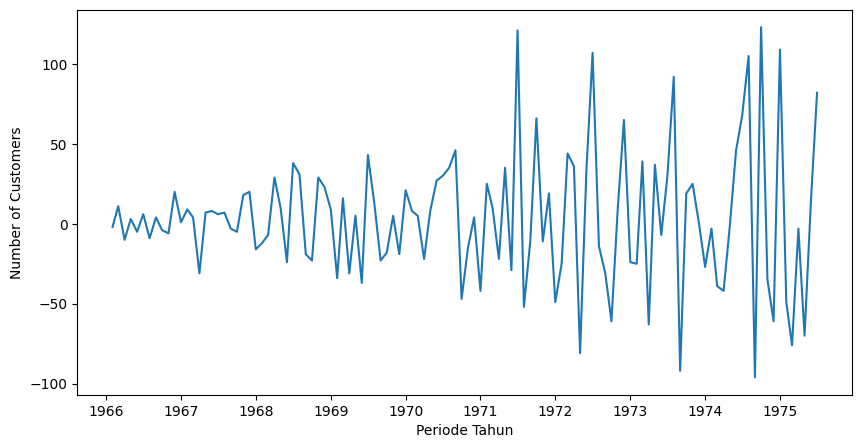

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('Periode Tahun')
plt.ylabel('Number of Customers')
plt.plot(stationary_data["First Differencing"])

## Determining the values of AutoRegressive (AR) from Partial Autocorrelation Function (PACF) and Moving Average (MA) from Autocorrelation Function (ACF).
To build an ARIMA model, the determination of the AR and MA values is done by identifying the PACF (Partial Autocorrelation Function) and ACF (Autocorrelation Function) graphs.

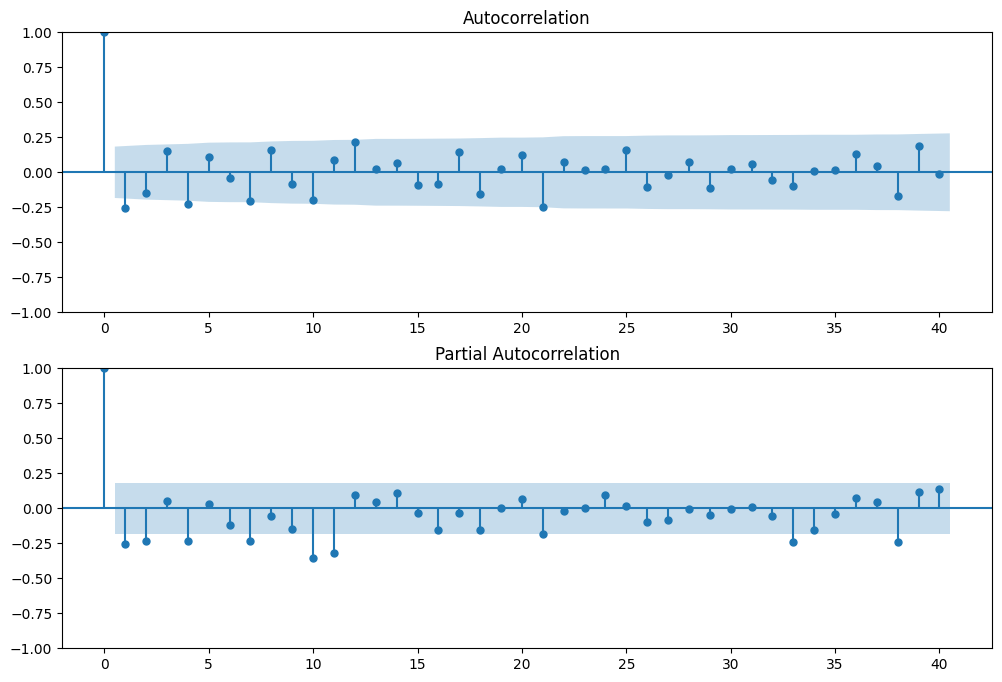

In [ ]:
# Determining the AR (PACF) and MA (ACF) values.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stationary_data['First Differencing'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stationary_data['First Differencing'].dropna(),lags=40,ax=ax2)


From the ACF and PACF correlograms after the log transformation:

It can be observed that the PACF plot (partial autocorrelation) is not significant at lag 1 and lag 2. Therefore, we obtain AR(2) with p = 2.

The data is differenced once, so d = 1.

Moreover, the ACF (autocorrelation) plot does not show significance at lag 1, suggesting that the data might be generated by MA(1) or d = 1.

Thus, based on points a, b, and c, it is concluded that the ARIMA model formed is ARIMA(2, 1, 1).
<br>
<br>

## Modeling ARIMA (Parameter Estimation):
Parameter estimation involves listing possible models to perform forecasting and conducting hypothesis testing for each model.

The significance hypothesis test is as follows:
H0: Coefficients are not significant.
H1: Coefficients are significant.

Below is the ARIMA (2,1,1) modeling conducted.

In [ ]:
model = ARIMA(train_data['Robberies'],order=(2,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Robberies   No. Observations:                  115
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -578.234
Date:                Sat, 05 Aug 2023   AIC                           1164.468
Time:                        05:57:27   BIC                           1175.413
Sample:                    01-01-1966   HQIC                          1168.910
                         - 07-01-1975                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8703      0.200     -4.348      0.000      -1.263      -0.478
ar.L2         -0.3741      0.081     -4.607      0.000      -0.533      -0.215
ma.L1          0.5968      0.205      2.918      0.004       0.196       0.998
sigma2      1486.4509    151.217      9.830      0.000    1190.070    1782.832
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                18.30
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):              10.81   Skew:                             0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on the significance test results (shown above) on the ARIMA(2,1,1) model, it can be observed that the coefficients ar1, ar2, and ma1 have p-values smaller than α=0.05. Therefore, we reject the null hypothesis (H0) and conclude that the coefficients ar1, ar2, and ma1 are significant. This indicates that the ARIMA(2,1,1) model can be used for prediction purposes.

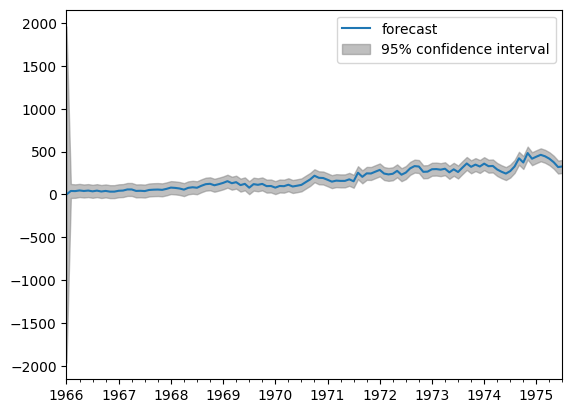

In [ ]:
plot_predict(model_fit)
plt.show()

The plot above represents the fitting of the model between the original data and the confidence interval. It can be observed from the plot that the predicted results and the original data exhibit the same pattern with conf 95%

##Performing Forecasting

From the results of identification and parameter estimation, an ARIMA(2,1,1) model was obtained. Consequently, using this model, forecasting is conducted for the next 3 periods.

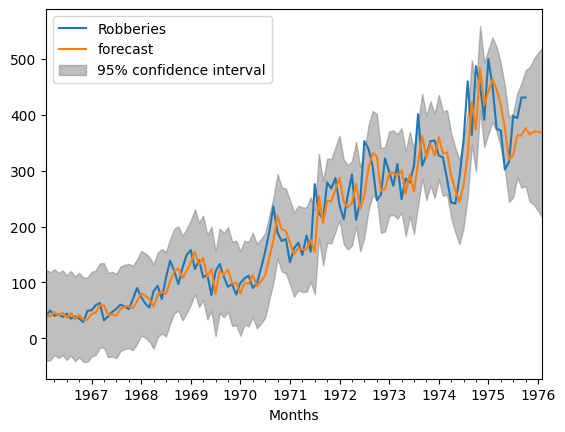

In [ ]:
# Prediction for the Next 3 Periods
fig, ax = plt.subplots()
ax = data[1:].plot(ax=ax)
plot_predict(model_fit, 1, len(train_data) + len(test_data)+3,ax=ax,dynamic=False)
plt.show()

In [ ]:
# Forecast the future values
fc, se, conf = model_fit.forecast(len(test_data), alpha=0.05)  # 95% confidence interval

# Calculate lower and upper bounds using forecast and confidence interval value
lower_bound = fc - conf
upper_bound = fc + conf

# Creating a Series for forecast, lower bound, and upper bound
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(lower_bound, index=test_data.index)
upper_series = pd.Series(upper_bound, index=test_data.index)

#### MAPE
The value commonly used to assess a model is MAPE or Mean Absolute Percentage Error. MAPE is an evaluation calculation used to measure how precise or accurate a prediction is. It allows us to obtain the difference between the actual value and the predicted value.

In [ ]:
mape = np.mean(np.abs(test_data["Robberies"] - fc_series)/np.abs(fc_series))*100
mape

15.223000786387853

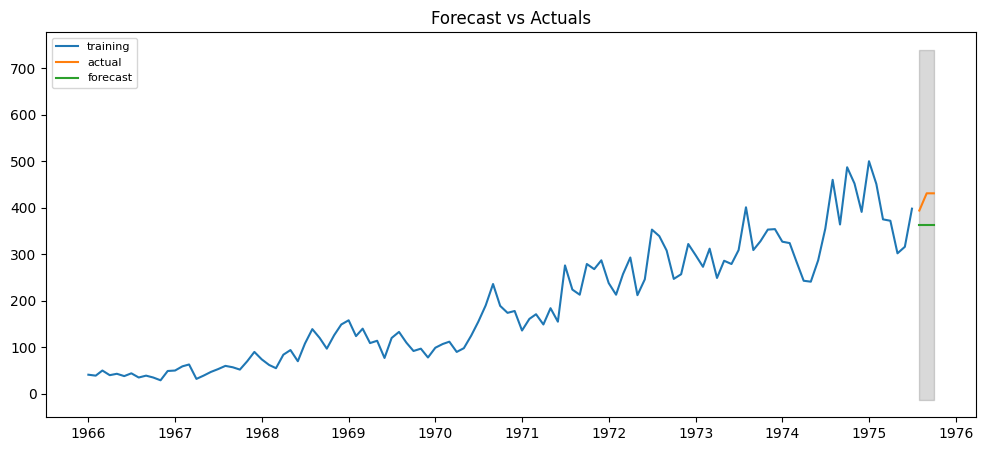

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data["Robberies"], label='training')
plt.plot(test_data["Robberies"], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
fc_series

Months
1975-08-01    363.353379
1975-09-01    363.353379
1975-10-01    363.353379
dtype: float64

##Additional Steps in Performing ARIMA Model Differentiation

In [ ]:
# Arrima 2,1,0
model = ARIMA(train_data['Robberies'],order=(2,1,0))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Robberies   No. Observations:                  115
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -579.777
Date:                Sat, 05 Aug 2023   AIC                           1165.553
Time:                        05:57:29   BIC                           1173.762
Sample:                    01-01-1966   HQIC                          1168.885
                         - 07-01-1975                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3190      0.076     -4.201      0.000      -0.468      -0.170
ar.L2         -0.2330      0.073     -3.171      0.002      -0.377      -0.089
sigma2      1528.4737    154.326      9.904      0.000    1226.000    1830.948
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                23.97
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              12.29   Skew:                             0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:


# Forecast the future values
fc_0, se_0, conf_0 = model_fit.forecast(len(test_data), alpha=0.05)  # 95% confidence interval

# Calculate lower and upper bounds using forecast and confidence interval value
lower_bound = fc_0 - conf_0
upper_bound =fc_0 + conf_0

# Creating a Series for forecast, lower bound, and upper bound
fc_series_0 = pd.Series(fc, index=test_data.index)
lower_series_0 = pd.Series(lower_bound, index=test_data.index)
upper_series_0 = pd.Series(upper_bound, index=test_data.index)

In [ ]:
mape_0 = np.mean(np.abs(test_data["Robberies"] - fc_series_0)/np.abs(fc_series_0))*100
mape_0

15.223000786387853

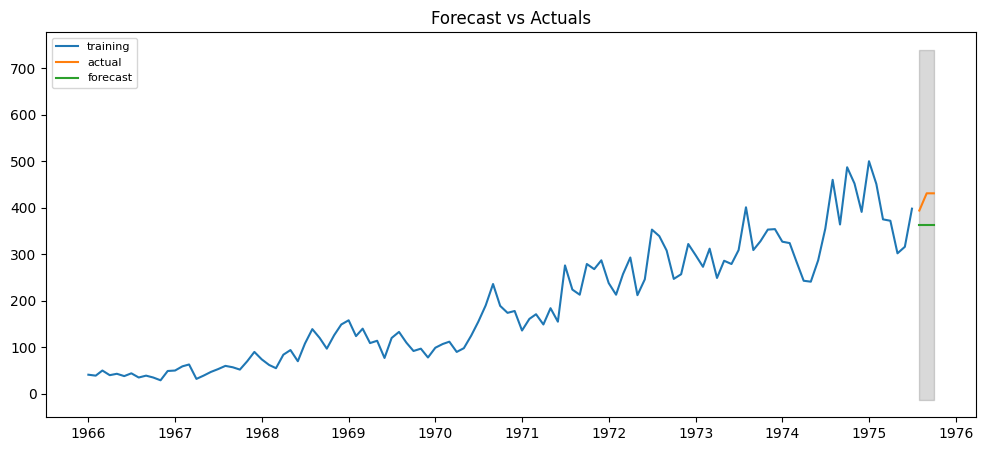

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data["Robberies"], label='training')
plt.plot(test_data["Robberies"], label='actual')
plt.plot(fc_series_0, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()